In [12]:
# magic output of plotting commands is displayed inline
%matplotlib inline

# import packages, framework and libraries 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# import Zalando's MNIST-alike dataset
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data-fashion/fashion')


Extracting data-fashion/fashion/train-images-idx3-ubyte.gz
Extracting data-fashion/fashion/train-labels-idx1-ubyte.gz
Extracting data-fashion/fashion/t10k-images-idx3-ubyte.gz
Extracting data-fashion/fashion/t10k-labels-idx1-ubyte.gz


55000


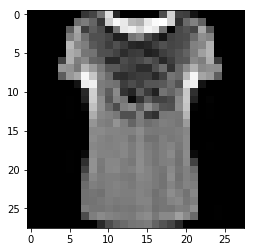

In [13]:
print(len(data.train.images))

img = data.train.images[1]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

In [ ]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides, padding):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    :padding: text indicating valid or same padding
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    padding = 'SAME'   
    feature_map = x_tensor.get_shape()[3].value
    weight = tf.Variable(tf.random_normal([conv_ksize[0], conv_ksize[1], feature_map, conv_num_outputs], mean=0.0, stddev=0.01))
    bias = tf.Variable(tf.zeros([conv_num_outputs]))
    conv_layer = tf.nn.conv2d(x_tensor, weight, strides=[1, conv_strides[0], conv_strides[1], 1], padding=padding)
    conv_layer = tf.nn.bias_add(conv_layer, bias)
    conv_layer = tf.nn.relu(conv_layer)
    # tf.nn.max_pool(conv_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    pool_layer = tf.nn.max_pool(conv_layer, 
                                ksize=[1, pool_ksize[0], pool_ksize[1], 1],
                                strides=[1, pool_strides[0], pool_strides[1], 1],
                                padding=padding)
            
    return pool_layer 

In [21]:
# Define placeholders, no size for batch defined so None, and images are MNIST alike 28x28 greyscale
inputs = tf.placeholder(tf.float32, (None, 28,28, 1), name='inputs')
targets = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

# Encoder (from 28x28x1 --> 4x4x8), the compressed represetation is going to be a pooling layer
# we don't want to potentially loose information padding --> same
# since we want a reduced representation of the image, we try a bigger 
# filter (feature map) initally and we gradually reduce it at each convolution

### Encoder
# Conv 1 + Maxpool
conv1 = tf.layers.conv2d(inputs, 64, (2,2), padding='same', activation=tf.nn.relu) # 28x28x64
# tuples for maxpool layer: pool_size and strides
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same') # 14x14x64
# Conv 2 + Maxpool
conv2 = tf.layers.conv2d(maxpool1, 32, (2,2), padding='same', activation=tf.nn.relu) # 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same') # 7x7x32
# Conv 3 + Maxpool 
conv3 = tf.layers.conv2d(maxpool2, 16, (1,1), padding='same', activation=tf.nn.relu) # 7x7x16
maxpool3 = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same') # 4x4x16
# Conv 4 + Maxpool
conv4 = tf.layers.conv2d(maxpool3, 8, (1,1), padding='same', activation=tf.nn.relu) # 4x4x8
maxpool4 = tf.layers.max_pooling2d(conv4, (2,2), (2,2), padding='same') # 2x2x8
# Conv
conv5 = tf.layers.conv2d(maxpool4, 4, (1,1), padding='same', activation=tf.nn.relu) # 2x2x4
encoded = tf.layers.max_pooling2d(conv5, (2,2), (1,1), padding='same') # 2x2x4
print(encoded.shape) # (?, 2, 2, 4)

(?, 2, 2, 4)


In [22]:
### Decoder

# Resize images to size using nearest neighbor interpolation
upsample1 = tf.image.resize_nearest_neighbor(encoded, (4,4)) # 4x4x4 
deconv1 = tf.layers.conv2d(upsample1, 8, (2,2), padding='same', activation=tf.nn.relu) # 4x4x8
upsample2 = tf.image.resize_nearest_neighbor(deconv1, (7,7)) # 7x7x8 
deconv2 = tf.layers.conv2d(upsample2, 16, (2,2), padding='same', activation=tf.nn.relu) # 7x7x16
upsample3 = tf.image.resize_nearest_neighbor(deconv2, (14,14)) # 14x14x8
deconv3 = tf.layers.conv2d(upsample3, 32, (2,2), padding='same', activation=tf.nn.relu) # 14x14x32
upsample4 = tf.image.resize_nearest_neighbor(deconv3, (28,28)) # 28x28x8
deconv4 = tf.layers.conv2d(upsample4, 64, (3,3), padding='same', activation=tf.nn.relu) # 28x28x16
print(deconv4.shape)

(?, 28, 28, 64)


In [23]:
# Hyperparameters 
lr = 0.001

# output layer 28x28x1
output = tf.layers.conv2d(deconv4, 1, (2,2), padding='same', activation=None) #logits 
decoded = tf.nn.sigmoid(output, name='decoded')

# compute the distance output vs target
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets, logits=output)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate = lr).minimize(cost)

In [24]:
sess = tf.Session()

In [25]:
epochs = 20
batch_size = 300
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(len(data.train.images) // batch_size): 
        batch = data.train.next_batch(batch_size)
        
        # https://stackoverflow.com/questions/41848660/why-the-negative-reshape-1-in-mnist-tutorial
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _= sess.run([cost, opt], feed_dict={inputs: imgs, targets: imgs})
        
        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))
        

Epoch: 1/20... Training loss: 0.6932
Epoch: 1/20... Training loss: 0.6913
Epoch: 1/20... Training loss: 0.6893
Epoch: 1/20... Training loss: 0.6870
Epoch: 1/20... Training loss: 0.6836
Epoch: 1/20... Training loss: 0.6795
Epoch: 1/20... Training loss: 0.6748
Epoch: 1/20... Training loss: 0.6692
Epoch: 1/20... Training loss: 0.6613
Epoch: 1/20... Training loss: 0.6569
Epoch: 1/20... Training loss: 0.6466
Epoch: 1/20... Training loss: 0.6411
Epoch: 1/20... Training loss: 0.6312
Epoch: 1/20... Training loss: 0.6255
Epoch: 1/20... Training loss: 0.6379
Epoch: 1/20... Training loss: 0.6381
Epoch: 1/20... Training loss: 0.6210
Epoch: 1/20... Training loss: 0.6323
Epoch: 1/20... Training loss: 0.6233
Epoch: 1/20... Training loss: 0.6130
Epoch: 1/20... Training loss: 0.6190
Epoch: 1/20... Training loss: 0.6225
Epoch: 1/20... Training loss: 0.6123
Epoch: 1/20... Training loss: 0.6187
Epoch: 1/20... Training loss: 0.6099
Epoch: 1/20... Training loss: 0.6025
Epoch: 1/20... Training loss: 0.6077
E

Epoch: 2/20... Training loss: 0.4394
Epoch: 2/20... Training loss: 0.4367
Epoch: 2/20... Training loss: 0.4398
Epoch: 2/20... Training loss: 0.4239
Epoch: 2/20... Training loss: 0.4294
Epoch: 2/20... Training loss: 0.4274
Epoch: 2/20... Training loss: 0.4290
Epoch: 2/20... Training loss: 0.4451
Epoch: 2/20... Training loss: 0.4227
Epoch: 2/20... Training loss: 0.4327
Epoch: 2/20... Training loss: 0.4198
Epoch: 2/20... Training loss: 0.4268
Epoch: 2/20... Training loss: 0.4378
Epoch: 2/20... Training loss: 0.4223
Epoch: 2/20... Training loss: 0.4322
Epoch: 2/20... Training loss: 0.4229
Epoch: 2/20... Training loss: 0.4266
Epoch: 2/20... Training loss: 0.4298
Epoch: 2/20... Training loss: 0.4176
Epoch: 2/20... Training loss: 0.4236
Epoch: 2/20... Training loss: 0.4174
Epoch: 2/20... Training loss: 0.4181
Epoch: 2/20... Training loss: 0.4183
Epoch: 2/20... Training loss: 0.4194
Epoch: 2/20... Training loss: 0.4146
Epoch: 2/20... Training loss: 0.4325
Epoch: 2/20... Training loss: 0.4212
E

Epoch: 3/20... Training loss: 0.3847
Epoch: 3/20... Training loss: 0.3660
Epoch: 3/20... Training loss: 0.3761
Epoch: 3/20... Training loss: 0.3755
Epoch: 3/20... Training loss: 0.3855
Epoch: 3/20... Training loss: 0.3742
Epoch: 3/20... Training loss: 0.3924
Epoch: 3/20... Training loss: 0.3859
Epoch: 3/20... Training loss: 0.3838
Epoch: 3/20... Training loss: 0.3727
Epoch: 3/20... Training loss: 0.3796
Epoch: 3/20... Training loss: 0.3754
Epoch: 3/20... Training loss: 0.3746
Epoch: 3/20... Training loss: 0.3813
Epoch: 3/20... Training loss: 0.3704
Epoch: 3/20... Training loss: 0.3712
Epoch: 3/20... Training loss: 0.3808
Epoch: 3/20... Training loss: 0.3764
Epoch: 3/20... Training loss: 0.3722
Epoch: 3/20... Training loss: 0.3755
Epoch: 3/20... Training loss: 0.3691
Epoch: 3/20... Training loss: 0.3810
Epoch: 3/20... Training loss: 0.3797
Epoch: 3/20... Training loss: 0.3826
Epoch: 3/20... Training loss: 0.3899
Epoch: 3/20... Training loss: 0.3683
Epoch: 3/20... Training loss: 0.3664
E

Epoch: 4/20... Training loss: 0.3708
Epoch: 4/20... Training loss: 0.3622
Epoch: 4/20... Training loss: 0.3598
Epoch: 4/20... Training loss: 0.3655
Epoch: 4/20... Training loss: 0.3601
Epoch: 4/20... Training loss: 0.3615
Epoch: 4/20... Training loss: 0.3613
Epoch: 4/20... Training loss: 0.3611
Epoch: 4/20... Training loss: 0.3600
Epoch: 4/20... Training loss: 0.3627
Epoch: 4/20... Training loss: 0.3496
Epoch: 4/20... Training loss: 0.3658
Epoch: 4/20... Training loss: 0.3597
Epoch: 4/20... Training loss: 0.3638
Epoch: 4/20... Training loss: 0.3657
Epoch: 4/20... Training loss: 0.3494
Epoch: 4/20... Training loss: 0.3595
Epoch: 4/20... Training loss: 0.3609
Epoch: 4/20... Training loss: 0.3606
Epoch: 4/20... Training loss: 0.3590
Epoch: 4/20... Training loss: 0.3589
Epoch: 4/20... Training loss: 0.3619
Epoch: 4/20... Training loss: 0.3731
Epoch: 4/20... Training loss: 0.3636
Epoch: 4/20... Training loss: 0.3622
Epoch: 4/20... Training loss: 0.3633
Epoch: 4/20... Training loss: 0.3666
E

Epoch: 5/20... Training loss: 0.3521
Epoch: 5/20... Training loss: 0.3494
Epoch: 5/20... Training loss: 0.3529
Epoch: 5/20... Training loss: 0.3580
Epoch: 5/20... Training loss: 0.3473
Epoch: 5/20... Training loss: 0.3490
Epoch: 5/20... Training loss: 0.3463
Epoch: 5/20... Training loss: 0.3631
Epoch: 5/20... Training loss: 0.3552
Epoch: 5/20... Training loss: 0.3556
Epoch: 5/20... Training loss: 0.3592
Epoch: 5/20... Training loss: 0.3533
Epoch: 5/20... Training loss: 0.3613
Epoch: 5/20... Training loss: 0.3528
Epoch: 5/20... Training loss: 0.3463
Epoch: 5/20... Training loss: 0.3559
Epoch: 5/20... Training loss: 0.3548
Epoch: 5/20... Training loss: 0.3637
Epoch: 5/20... Training loss: 0.3643
Epoch: 5/20... Training loss: 0.3571
Epoch: 5/20... Training loss: 0.3510
Epoch: 6/20... Training loss: 0.3613
Epoch: 6/20... Training loss: 0.3433
Epoch: 6/20... Training loss: 0.3550
Epoch: 6/20... Training loss: 0.3684
Epoch: 6/20... Training loss: 0.3509
Epoch: 6/20... Training loss: 0.3581
E

Epoch: 7/20... Training loss: 0.3429
Epoch: 7/20... Training loss: 0.3506
Epoch: 7/20... Training loss: 0.3501
Epoch: 7/20... Training loss: 0.3570
Epoch: 7/20... Training loss: 0.3506
Epoch: 7/20... Training loss: 0.3580
Epoch: 7/20... Training loss: 0.3531
Epoch: 7/20... Training loss: 0.3545
Epoch: 7/20... Training loss: 0.3400
Epoch: 7/20... Training loss: 0.3496
Epoch: 7/20... Training loss: 0.3543
Epoch: 7/20... Training loss: 0.3436
Epoch: 7/20... Training loss: 0.3521
Epoch: 7/20... Training loss: 0.3541
Epoch: 7/20... Training loss: 0.3418
Epoch: 7/20... Training loss: 0.3583
Epoch: 7/20... Training loss: 0.3424
Epoch: 7/20... Training loss: 0.3460
Epoch: 7/20... Training loss: 0.3492
Epoch: 7/20... Training loss: 0.3464
Epoch: 7/20... Training loss: 0.3568
Epoch: 7/20... Training loss: 0.3455
Epoch: 7/20... Training loss: 0.3477
Epoch: 7/20... Training loss: 0.3483
Epoch: 7/20... Training loss: 0.3473
Epoch: 7/20... Training loss: 0.3468
Epoch: 7/20... Training loss: 0.3429
E

Epoch: 8/20... Training loss: 0.3500
Epoch: 8/20... Training loss: 0.3526
Epoch: 8/20... Training loss: 0.3450
Epoch: 8/20... Training loss: 0.3603
Epoch: 8/20... Training loss: 0.3415
Epoch: 8/20... Training loss: 0.3402
Epoch: 8/20... Training loss: 0.3502
Epoch: 8/20... Training loss: 0.3593
Epoch: 8/20... Training loss: 0.3470
Epoch: 8/20... Training loss: 0.3474
Epoch: 8/20... Training loss: 0.3502
Epoch: 8/20... Training loss: 0.3397
Epoch: 8/20... Training loss: 0.3455
Epoch: 8/20... Training loss: 0.3517
Epoch: 8/20... Training loss: 0.3384
Epoch: 8/20... Training loss: 0.3443
Epoch: 8/20... Training loss: 0.3497
Epoch: 8/20... Training loss: 0.3483
Epoch: 8/20... Training loss: 0.3400
Epoch: 8/20... Training loss: 0.3543
Epoch: 8/20... Training loss: 0.3433
Epoch: 8/20... Training loss: 0.3472
Epoch: 8/20... Training loss: 0.3498
Epoch: 8/20... Training loss: 0.3449
Epoch: 8/20... Training loss: 0.3503
Epoch: 8/20... Training loss: 0.3432
Epoch: 8/20... Training loss: 0.3655
E

Epoch: 9/20... Training loss: 0.3436
Epoch: 9/20... Training loss: 0.3527
Epoch: 9/20... Training loss: 0.3641
Epoch: 9/20... Training loss: 0.3458
Epoch: 9/20... Training loss: 0.3512
Epoch: 9/20... Training loss: 0.3441
Epoch: 9/20... Training loss: 0.3529
Epoch: 9/20... Training loss: 0.3380
Epoch: 9/20... Training loss: 0.3410
Epoch: 9/20... Training loss: 0.3410
Epoch: 9/20... Training loss: 0.3471
Epoch: 9/20... Training loss: 0.3331
Epoch: 9/20... Training loss: 0.3491
Epoch: 9/20... Training loss: 0.3455
Epoch: 9/20... Training loss: 0.3472
Epoch: 9/20... Training loss: 0.3385
Epoch: 9/20... Training loss: 0.3449
Epoch: 9/20... Training loss: 0.3378
Epoch: 9/20... Training loss: 0.3371
Epoch: 9/20... Training loss: 0.3495
Epoch: 9/20... Training loss: 0.3439
Epoch: 9/20... Training loss: 0.3419
Epoch: 9/20... Training loss: 0.3485
Epoch: 9/20... Training loss: 0.3442
Epoch: 9/20... Training loss: 0.3378
Epoch: 9/20... Training loss: 0.3432
Epoch: 9/20... Training loss: 0.3413
E

Epoch: 10/20... Training loss: 0.3424
Epoch: 10/20... Training loss: 0.3417
Epoch: 10/20... Training loss: 0.3451
Epoch: 10/20... Training loss: 0.3439
Epoch: 10/20... Training loss: 0.3366
Epoch: 10/20... Training loss: 0.3356
Epoch: 10/20... Training loss: 0.3422
Epoch: 10/20... Training loss: 0.3527
Epoch: 10/20... Training loss: 0.3430
Epoch: 10/20... Training loss: 0.3408
Epoch: 10/20... Training loss: 0.3429
Epoch: 10/20... Training loss: 0.3441
Epoch: 10/20... Training loss: 0.3439
Epoch: 10/20... Training loss: 0.3518
Epoch: 10/20... Training loss: 0.3475
Epoch: 10/20... Training loss: 0.3382
Epoch: 10/20... Training loss: 0.3430
Epoch: 10/20... Training loss: 0.3429
Epoch: 10/20... Training loss: 0.3385
Epoch: 10/20... Training loss: 0.3364
Epoch: 10/20... Training loss: 0.3401
Epoch: 10/20... Training loss: 0.3436
Epoch: 10/20... Training loss: 0.3385
Epoch: 10/20... Training loss: 0.3422
Epoch: 10/20... Training loss: 0.3393
Epoch: 10/20... Training loss: 0.3487
Epoch: 10/20

Epoch: 11/20... Training loss: 0.3337
Epoch: 11/20... Training loss: 0.3376
Epoch: 11/20... Training loss: 0.3396
Epoch: 11/20... Training loss: 0.3419
Epoch: 11/20... Training loss: 0.3441
Epoch: 11/20... Training loss: 0.3414
Epoch: 11/20... Training loss: 0.3473
Epoch: 11/20... Training loss: 0.3477
Epoch: 11/20... Training loss: 0.3373
Epoch: 11/20... Training loss: 0.3397
Epoch: 12/20... Training loss: 0.3410
Epoch: 12/20... Training loss: 0.3450
Epoch: 12/20... Training loss: 0.3520
Epoch: 12/20... Training loss: 0.3382
Epoch: 12/20... Training loss: 0.3469
Epoch: 12/20... Training loss: 0.3433
Epoch: 12/20... Training loss: 0.3291
Epoch: 12/20... Training loss: 0.3391
Epoch: 12/20... Training loss: 0.3420
Epoch: 12/20... Training loss: 0.3494
Epoch: 12/20... Training loss: 0.3293
Epoch: 12/20... Training loss: 0.3426
Epoch: 12/20... Training loss: 0.3340
Epoch: 12/20... Training loss: 0.3363
Epoch: 12/20... Training loss: 0.3387
Epoch: 12/20... Training loss: 0.3420
Epoch: 12/20

Epoch: 13/20... Training loss: 0.3384
Epoch: 13/20... Training loss: 0.3348
Epoch: 13/20... Training loss: 0.3415
Epoch: 13/20... Training loss: 0.3390
Epoch: 13/20... Training loss: 0.3437
Epoch: 13/20... Training loss: 0.3456
Epoch: 13/20... Training loss: 0.3492
Epoch: 13/20... Training loss: 0.3359
Epoch: 13/20... Training loss: 0.3373
Epoch: 13/20... Training loss: 0.3399
Epoch: 13/20... Training loss: 0.3301
Epoch: 13/20... Training loss: 0.3469
Epoch: 13/20... Training loss: 0.3214
Epoch: 13/20... Training loss: 0.3310
Epoch: 13/20... Training loss: 0.3359
Epoch: 13/20... Training loss: 0.3394
Epoch: 13/20... Training loss: 0.3381
Epoch: 13/20... Training loss: 0.3422
Epoch: 13/20... Training loss: 0.3339
Epoch: 13/20... Training loss: 0.3395
Epoch: 13/20... Training loss: 0.3416
Epoch: 13/20... Training loss: 0.3315
Epoch: 13/20... Training loss: 0.3287
Epoch: 13/20... Training loss: 0.3359
Epoch: 13/20... Training loss: 0.3345
Epoch: 13/20... Training loss: 0.3364
Epoch: 13/20

Epoch: 14/20... Training loss: 0.3387
Epoch: 14/20... Training loss: 0.3368
Epoch: 14/20... Training loss: 0.3344
Epoch: 14/20... Training loss: 0.3387
Epoch: 14/20... Training loss: 0.3370
Epoch: 14/20... Training loss: 0.3305
Epoch: 14/20... Training loss: 0.3402
Epoch: 14/20... Training loss: 0.3335
Epoch: 14/20... Training loss: 0.3290
Epoch: 14/20... Training loss: 0.3320
Epoch: 14/20... Training loss: 0.3359
Epoch: 14/20... Training loss: 0.3382
Epoch: 14/20... Training loss: 0.3388
Epoch: 14/20... Training loss: 0.3418
Epoch: 14/20... Training loss: 0.3333
Epoch: 14/20... Training loss: 0.3463
Epoch: 14/20... Training loss: 0.3372
Epoch: 14/20... Training loss: 0.3361
Epoch: 14/20... Training loss: 0.3510
Epoch: 14/20... Training loss: 0.3427
Epoch: 14/20... Training loss: 0.3381
Epoch: 14/20... Training loss: 0.3287
Epoch: 14/20... Training loss: 0.3383
Epoch: 14/20... Training loss: 0.3333
Epoch: 14/20... Training loss: 0.3407
Epoch: 14/20... Training loss: 0.3427
Epoch: 14/20

Epoch: 15/20... Training loss: 0.3346
Epoch: 15/20... Training loss: 0.3308
Epoch: 15/20... Training loss: 0.3398
Epoch: 15/20... Training loss: 0.3338
Epoch: 15/20... Training loss: 0.3388
Epoch: 15/20... Training loss: 0.3326
Epoch: 15/20... Training loss: 0.3379
Epoch: 15/20... Training loss: 0.3285
Epoch: 15/20... Training loss: 0.3407
Epoch: 15/20... Training loss: 0.3401
Epoch: 15/20... Training loss: 0.3402
Epoch: 15/20... Training loss: 0.3327
Epoch: 15/20... Training loss: 0.3343
Epoch: 15/20... Training loss: 0.3263
Epoch: 15/20... Training loss: 0.3350
Epoch: 15/20... Training loss: 0.3417
Epoch: 15/20... Training loss: 0.3360
Epoch: 15/20... Training loss: 0.3422
Epoch: 15/20... Training loss: 0.3316
Epoch: 15/20... Training loss: 0.3321
Epoch: 15/20... Training loss: 0.3310
Epoch: 15/20... Training loss: 0.3430
Epoch: 15/20... Training loss: 0.3306
Epoch: 15/20... Training loss: 0.3306
Epoch: 15/20... Training loss: 0.3289
Epoch: 15/20... Training loss: 0.3399
Epoch: 15/20

Epoch: 16/20... Training loss: 0.3363
Epoch: 16/20... Training loss: 0.3334
Epoch: 16/20... Training loss: 0.3301
Epoch: 16/20... Training loss: 0.3271
Epoch: 16/20... Training loss: 0.3322
Epoch: 16/20... Training loss: 0.3426
Epoch: 16/20... Training loss: 0.3327
Epoch: 16/20... Training loss: 0.3332
Epoch: 16/20... Training loss: 0.3311
Epoch: 16/20... Training loss: 0.3372
Epoch: 16/20... Training loss: 0.3390
Epoch: 16/20... Training loss: 0.3433
Epoch: 16/20... Training loss: 0.3369
Epoch: 16/20... Training loss: 0.3233
Epoch: 16/20... Training loss: 0.3386
Epoch: 16/20... Training loss: 0.3301
Epoch: 16/20... Training loss: 0.3357
Epoch: 16/20... Training loss: 0.3351
Epoch: 16/20... Training loss: 0.3318
Epoch: 16/20... Training loss: 0.3359
Epoch: 16/20... Training loss: 0.3414
Epoch: 16/20... Training loss: 0.3367
Epoch: 16/20... Training loss: 0.3322
Epoch: 16/20... Training loss: 0.3392
Epoch: 16/20... Training loss: 0.3362
Epoch: 16/20... Training loss: 0.3481
Epoch: 16/20

Epoch: 17/20... Training loss: 0.3400
Epoch: 17/20... Training loss: 0.3371
Epoch: 17/20... Training loss: 0.3301
Epoch: 17/20... Training loss: 0.3386
Epoch: 17/20... Training loss: 0.3468
Epoch: 17/20... Training loss: 0.3385
Epoch: 17/20... Training loss: 0.3209
Epoch: 17/20... Training loss: 0.3326
Epoch: 17/20... Training loss: 0.3305
Epoch: 17/20... Training loss: 0.3335
Epoch: 17/20... Training loss: 0.3304
Epoch: 17/20... Training loss: 0.3266
Epoch: 17/20... Training loss: 0.3370
Epoch: 17/20... Training loss: 0.3246
Epoch: 17/20... Training loss: 0.3278
Epoch: 17/20... Training loss: 0.3262
Epoch: 17/20... Training loss: 0.3289
Epoch: 17/20... Training loss: 0.3329
Epoch: 17/20... Training loss: 0.3265
Epoch: 17/20... Training loss: 0.3340
Epoch: 18/20... Training loss: 0.3238
Epoch: 18/20... Training loss: 0.3264
Epoch: 18/20... Training loss: 0.3273
Epoch: 18/20... Training loss: 0.3417
Epoch: 18/20... Training loss: 0.3261
Epoch: 18/20... Training loss: 0.3421
Epoch: 18/20

Epoch: 19/20... Training loss: 0.3262
Epoch: 19/20... Training loss: 0.3320
Epoch: 19/20... Training loss: 0.3293
Epoch: 19/20... Training loss: 0.3406
Epoch: 19/20... Training loss: 0.3324
Epoch: 19/20... Training loss: 0.3261
Epoch: 19/20... Training loss: 0.3358
Epoch: 19/20... Training loss: 0.3302
Epoch: 19/20... Training loss: 0.3233
Epoch: 19/20... Training loss: 0.3345
Epoch: 19/20... Training loss: 0.3202
Epoch: 19/20... Training loss: 0.3314
Epoch: 19/20... Training loss: 0.3455
Epoch: 19/20... Training loss: 0.3254
Epoch: 19/20... Training loss: 0.3245
Epoch: 19/20... Training loss: 0.3448
Epoch: 19/20... Training loss: 0.3353
Epoch: 19/20... Training loss: 0.3233
Epoch: 19/20... Training loss: 0.3387
Epoch: 19/20... Training loss: 0.3326
Epoch: 19/20... Training loss: 0.3367
Epoch: 19/20... Training loss: 0.3393
Epoch: 19/20... Training loss: 0.3339
Epoch: 19/20... Training loss: 0.3333
Epoch: 19/20... Training loss: 0.3293
Epoch: 19/20... Training loss: 0.3270
Epoch: 19/20

Epoch: 20/20... Training loss: 0.3339
Epoch: 20/20... Training loss: 0.3373
Epoch: 20/20... Training loss: 0.3233
Epoch: 20/20... Training loss: 0.3364
Epoch: 20/20... Training loss: 0.3305
Epoch: 20/20... Training loss: 0.3289
Epoch: 20/20... Training loss: 0.3289
Epoch: 20/20... Training loss: 0.3229
Epoch: 20/20... Training loss: 0.3309
Epoch: 20/20... Training loss: 0.3383
Epoch: 20/20... Training loss: 0.3257
Epoch: 20/20... Training loss: 0.3348
Epoch: 20/20... Training loss: 0.3307
Epoch: 20/20... Training loss: 0.3287
Epoch: 20/20... Training loss: 0.3297
Epoch: 20/20... Training loss: 0.3381
Epoch: 20/20... Training loss: 0.3319
Epoch: 20/20... Training loss: 0.3347
Epoch: 20/20... Training loss: 0.3366
Epoch: 20/20... Training loss: 0.3385
Epoch: 20/20... Training loss: 0.3414
Epoch: 20/20... Training loss: 0.3219
Epoch: 20/20... Training loss: 0.3356
Epoch: 20/20... Training loss: 0.3337
Epoch: 20/20... Training loss: 0.3305
Epoch: 20/20... Training loss: 0.3382
Epoch: 20/20

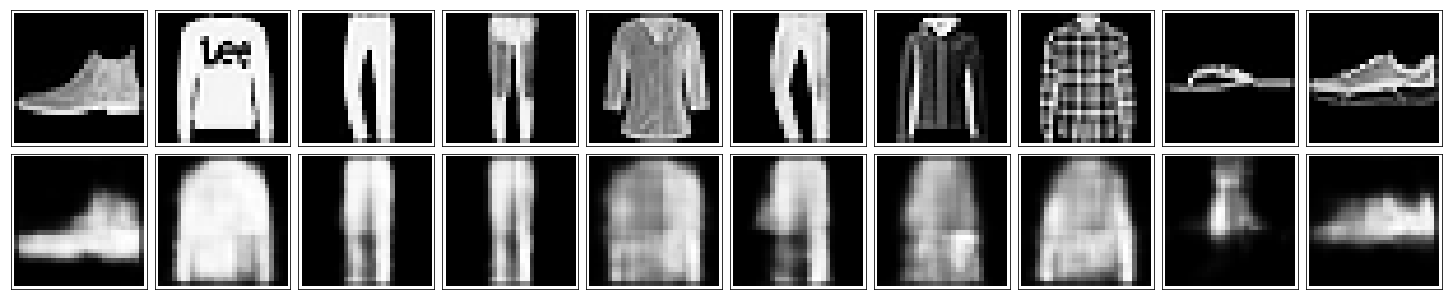

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = data.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)